# Crypto Price Prediction

Poloniex API docs: https://docs.poloniex.com/#returnchartdata

## Imports

In [1]:
import datetime
import pandas as pd
import requests
import time

## Getting the Data

In [2]:
current_date = int(datetime.datetime.now().strftime('%s'))
end_dt = current_date
time_interval = 365*5*86400
start_dt = end_dt - time_interval

In [3]:
def get_currency_price_data(currency_pair, start_dt, end_dt):
    '''
    '''
    window = 90*86400
    params = {
        'command': 'returnChartData',
        'currencyPair': currency_pair,
        'period': 300
    }
    price_df = pd.DataFrame()
    
    for start in range(start_dt, end_dt, window):
        params['start'] = start
        params['end'] = start + window
        response = requests.get(url='https://poloniex.com/public', params=params)
        # Should technically inspect the response here but I've noticed that a status_code == 200 doesn't necessarily imply that proper data was returned.  I've encountered errors where the API returned text claiming that the response was too large.
        price_df = pd.concat([price_df, pd.DataFrame(response.json())])
        # Possibly add wait period here before calling API again.  I've found it's unnecessary, though.
    
    return price_df

In [79]:
# 5 years of data is ~40MB.
eth_data = get_currency_price_data(currency_pair='USDT_ETH', start_dt=start_dt, end_dt=end_dt)

In [80]:
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447459 entries, 0 to 7201
Data columns (total 8 columns):
close              447459 non-null float64
date               447459 non-null int64
high               447459 non-null float64
low                447459 non-null float64
open               447459 non-null float64
quoteVolume        447459 non-null float64
volume             447459 non-null float64
weightedAverage    447459 non-null float64
dtypes: float64(7), int64(1)
memory usage: 30.7 MB


In [81]:
# 5 years of data is ~40MB.
btc_data = get_currency_price_data(currency_pair='USDT_BTC', start_dt=start_dt, end_dt=end_dt)

In [82]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496204 entries, 0 to 7201
Data columns (total 8 columns):
close              496204 non-null float64
date               496204 non-null int64
high               496204 non-null float64
low                496204 non-null float64
open               496204 non-null float64
quoteVolume        496204 non-null float64
volume             496204 non-null float64
weightedAverage    496204 non-null float64
dtypes: float64(7), int64(1)
memory usage: 34.1 MB


In [84]:
# btc_data.to_csv('data/btc_price.csv')

In [88]:
btc_data.head(5)

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.0
0,225.0,1424373000,225.0,225.0,225.0,0.004444,0.999999,225.0
1,225.0,1424373300,225.0,225.0,225.0,0.000000,0.000000,225.0
2,225.0,1424373600,225.0,225.0,225.0,0.000000,0.000000,225.0
3,225.0,1424373900,225.0,225.0,225.0,0.000000,0.000000,225.0


In [4]:
btc_data = pd.read_csv('data/btc_data.csv')
eth_data = pd.read_csv('data/eth_data.csv')

## PACF, ACF, AR Modeling and Stationarity Test

In [5]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [70]:
# Set default figure size.
from pylab import rcParams
rcParams['figure.figsize'] = 14,6

In [14]:
# # This takes way too long to run and tells us something we already know -- that the previous timestep is useful for predicting the current timestep.
# data = btc_data
# plt.plot(x=data.date, y=data.weightedAverage)
# lag_plot(data.weightedAverage)

In [ ]:
# # This takes too long to run for 500k data points.
# autocorrelation_plot(data.weightedAverage)

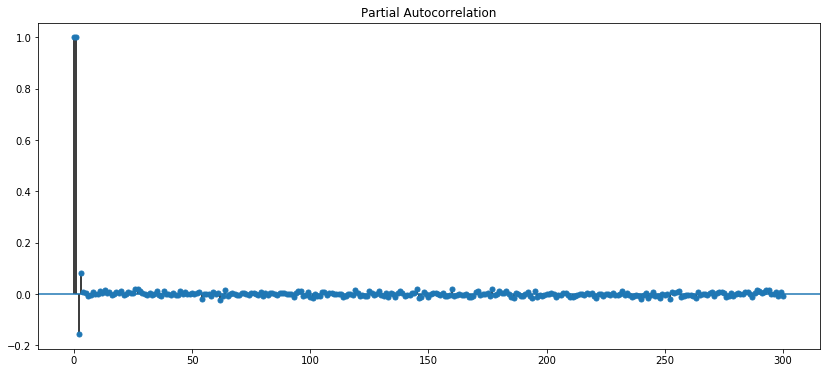

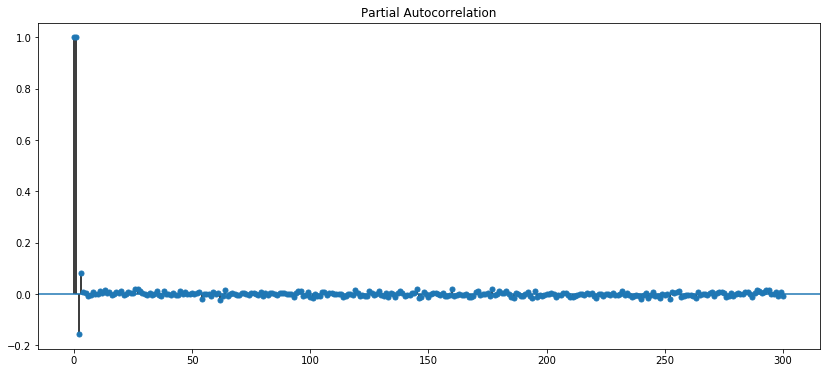

In [31]:
# The first time I plotted this I found something strange.  It was showing lags at 18, 36, ... were important, but this is only the case for BTC prices for the first part of the dataset.  The reason for this is probably that the first BTC price in the dataset is 0.  I also notice that if I plot different segments of the dataset, I get different results for the partial autocorrelation (e.g. plotting 0:50000 is different from 150000:200000, and it seems like the lag trends in the data change as ether evolves.)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = eth_data
# plot_pacf(data.weightedAverage.tolist()[250000:300000], lags=100)
plot_pacf(data.weightedAverage, lags=300)

Lag: 56
Coefficients: [ 1.73773687e-02  1.09306941e+00 -1.30185454e-01  4.59717585e-02
 -3.37831686e-02  9.09656442e-03  1.70861851e-02  8.74717146e-03
 -1.66993534e-02  2.43818643e-02 -1.82447935e-02 -1.11085021e-02
  9.84363164e-03 -8.73265827e-03  7.48689966e-03 -9.67206697e-03
  1.03187188e-02 -1.00245661e-03 -1.59475280e-03  5.26078819e-03
 -4.40214306e-03  4.21202075e-03  1.26496902e-03 -1.57886730e-02
  1.83096718e-02 -1.60967613e-02  2.99897126e-03  1.09705819e-02
 -6.42498724e-04 -1.74335925e-02  1.93858476e-02 -5.65149470e-03
 -3.96890085e-03  5.69938065e-03  3.57363035e-03 -2.13416414e-02
  2.42561853e-02 -2.29719037e-03  3.20446442e-03 -1.05524552e-02
  1.00993572e-02 -7.45262976e-03  8.40336195e-03 -1.05396505e-02
 -2.20986441e-03 -3.63626146e-03  8.05535617e-03  1.05153618e-02
 -6.61754805e-03 -1.05402586e-02  2.76554208e-02 -2.05554321e-02
  2.00083324e-03  4.95345926e-04 -5.34896618e-03  9.67678055e-03
 -6.02997023e-03]
predicted=186.039756, expected=186.027507
predicte

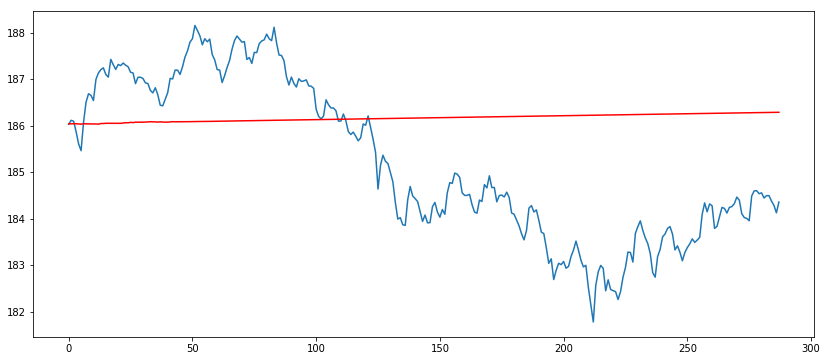

In [33]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

data = eth_data
X = data.weightedAverage.tolist()

# split data
train, test = X[400000:len(X)-288], X[len(X)-288:]

# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [129]:
# # Test for stationarity.  If p > 0.05, the series is **non-stationary**!
# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(data.weightedAverage.dropna())

## Verifying Data Continuity, Auto (S)ARIMA with AIC

Reference: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

In [97]:
btc_data_date = btc_data.copy()
# btc_data_date['date'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d))

In [98]:
from plotly.offline import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

In [88]:
# btc_data_date = btc_data_date.set_index('date')

In [99]:
btc_data_date = btc_data_date.iloc[100000:, ]

In [100]:
btc_data_date.head()

,Unnamed: 0,close,date,high,low,open,quoteVolume,volume,weightedAverage,dt
100000,25732,372.13,1454390400,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100001,25733,372.13,1454390700,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100002,25734,372.13,1454391000,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100003,25735,372.13,1454391300,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
100004,25736,372.13,1454391600,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02


In [101]:
btc_data_date['dt'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d).date())

In [104]:
grouped = btc_data_date.groupby('dt').count().reset_index()

In [105]:
import plotly.express as px
fig = px.line(grouped, x='dt', y='close')
fig.show()

In [108]:
btc_data_date['date'] = btc_data_date['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d))
btc_data_date = btc_data_date.set_index('date')

In [110]:
btc_data_date.head()

,Unnamed: 0,close,high,low,open,quoteVolume,volume,weightedAverage,dt
date,,,,,,,,,
2016-02-02 05:20:00,25732,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:25:00,25733,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:30:00,25734,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:35:00,25735,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02
2016-02-02 05:40:00,25736,372.13,372.13,372.13,372.13,0.0,0.0,372.13,2016-02-02


In [130]:
# "ValueError: You must specify a freq" occurs if the time series isn't evenly spaced
# This takes quite a long time to run for 500000 data points and freq of 12*24*365
# I still encounter the ValueError above when it seems like my time series is evenly spaced, but I haven't verified this 100%
# This modeling effort even takes a long time for 100k data points and frequency of 264
result = seasonal_decompose(btc_data_date['weightedAverage'].iloc[300000:, ], model='additive', freq=12*24)
fig = result.plot()
plot_mpl(fig)

'temp-plot.html'

In [128]:
# Couldn't install pyramid.arima.
from pyramid.arima import auto_arima
stepwise_model = auto_arima(btc_data_date.weightedAverage, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

ModuleNotFoundError: No module named 'pyramid.arima'

In [ ]:
train = data.loc['1985-01-01':'2016-12-01']
test = data.loc['2017-01-01':]

In [ ]:
stepwise_model.fit(train)

In [ ]:
future_forecast = stepwise_model.predict(n_periods=37)

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=[‘Prediction’])
pd.concat([test,future_forecast],axis=1).iplot()

In [ ]:
pd.concat([data,future_forecast],axis=1).iplot()

## Feature Engineering

In [156]:
dt = datetime.datetime.utcfromtimestamp(eth_data['date'][4]).hour

In [159]:
eth_data['hour'] = eth_data['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d).hour)
eth_data['month'] = eth_data['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d).month)
eth_data['dow'] = eth_data['date'].apply(lambda d: datetime.datetime.utcfromtimestamp(d).weekday())

## Explore Missing Data

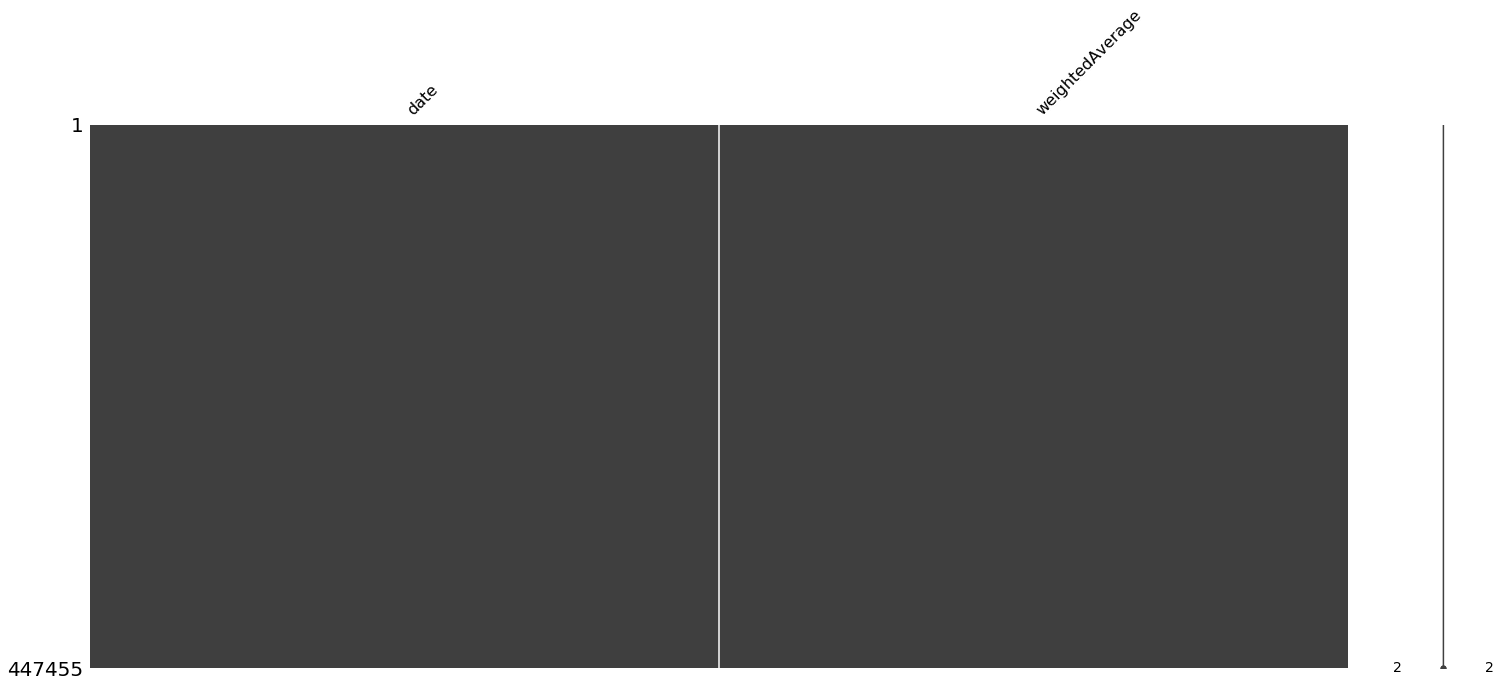

In [143]:
# Look for missing data.  Not the best way of appoaching this because really what we are interested in is seeing if every time step is equal.
import missingno as msno
msno.matrix(data);

## Lag Log Return Models

This section focuses on building models using the lag log return data only.  We'll try building models (random forest, gradient boosting, LSTM / sequence models) and comparing them to baseline models.  Some parameters we are interested are:

- Number of lags (L = {12, 12*24})
- Time steps into the future that we want to predict (t = {1, 3, 12, 12*24})
- The window of data used for train and test (recent data only?  long time windows?)
    - The advantage of a longer training time window is that we get more training data to work with, but the downside is that 

Ideas:

1. Find hours/time windows where the price doesn't change at all, and get rid of them.  Otherwise, the model will underpredict the absolute log return and the signal will be drowned out
2. Need to create baseline models:
    - The mean log return over the entire period
    - 0 return -- assumes the price won't change at all
3. Verify the data.  For example, look at date 1439018400 and adjacent dates for eth_data.  The price jumps from 1.85 to 0.5 and back, which doesn't make sense.  Building a model to predict the log returns will be hugely influenced by these noisy outliers, particularly with mean squared error.


In [309]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [310]:
data = eth_data.iloc[3:, ]
data = data[['date', 'weightedAverage', 'hour']]
data.columns = ['date', 'price', 'hour']
data.shape

(447455, 3)

In [311]:
data['price_lag_1'] = data['price'].shift(1)
data['return'] = data['price']/data['price_lag_1']
data['log_return'] = np.log(data['return'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



In [312]:
data = data.iloc[1:, ]

In [314]:
data.head(1)

,date,price,hour,price_lag_1,return,log_return
4,1439014800,1.85,6,1.67,1.107784,0.102362


In [315]:
def generate_log_return_lags(df, lags=1):
    for i in range(lags):
        df['log_return'+'_lag_' + str(i+1)] = df['log_return'].shift(i+1)
    return df

In [316]:
data = generate_log_return_lags(data, lags=12)

In [317]:
data = data.iloc[12:, ]

In [318]:
data.head()

,date,price,hour,price_lag_1,return,log_return,log_return_lag_1,log_return_lag_2,log_return_lag_3,log_return_lag_4,log_return_lag_5,log_return_lag_6,log_return_lag_7,log_return_lag_8,log_return_lag_9,log_return_lag_10,log_return_lag_11,log_return_lag_12
16,1439018400,0.50,7,1.748269,0.285997,-1.251773,-0.000990,0.023122,0.000000,0.000000,0.000000,-0.078692,0.000000,0.000000,0.000000,0.000000,0.0,0.102362
17,1439018700,1.85,7,0.500000,3.699998,1.308332,-1.251773,-0.000990,0.023122,0.000000,0.000000,0.000000,-0.078692,0.000000,0.000000,0.000000,0.0,0.000000
18,1439019000,1.85,7,1.850000,1.000000,0.000000,1.308332,-1.251773,-0.000990,0.023122,0.000000,0.000000,0.000000,-0.078692,0.000000,0.000000,0.0,0.000000
19,1439019300,1.85,7,1.850000,1.000000,0.000000,0.000000,1.308332,-1.251773,-0.000990,0.023122,0.000000,0.000000,0.000000,-0.078692,0.000000,0.0,0.000000
20,1439019600,1.85,7,1.850000,1.000000,0.000000,0.000000,0.000000,1.308332,-1.251773,-0.000990,0.023122,0.000000,0.000000,0.000000,-0.078692,0.0,0.000000


#### Visualize a Subset of the Data

Noticed from quickly looking at this that maybe the first 100k data points shouldn't be used for ether because for the most part all of the log returns are zero.  Ether must not have been actively traded as much at that point.

In [319]:
import plotly.express as px
small_data = data.iloc[0:12*24*7]  # Log return is almost always 0 for the early part of the dataset.
# small_data = data.iloc[350000:350000+12*24*7]  # It appears that over a week, the log return is actually very rarely completely flat.
# small_data = data.iloc[100000:100000+12*24*7]  # It appears that over a week, the log return is actually very rarely completely flat.
fig = px.line(small_data, x='date', y='log_return')
fig.show()

#### Split Data Once Into Train and Test, Try Random Forest and Gradient Boosting Regressors

In [300]:
# Chuck away early part of dataset that is misleading.
small_data = data.iloc[425000:]
X = np.array(small_data.filter(regex=('log_return_lag*')))
y = np.array(small_data['log_return'])

In [301]:
train_window = 12*24*28  # 4 weeks
test_window = 12*24*7  # 1 week
X_train, X_test = X[0:train_window, :], X[train_window:train_window+test_window, :]
y_train, y_test = y[0:train_window], y[train_window:train_window+test_window]

In [302]:
# Baseline model.
train_data = small_data.iloc[0:train_window, :]
test_data = small_data.iloc[train_window:train_window+test_window, :]
mean_log_return = np.mean(train_data['log_return'])
print('Mean log return in training period: ' + str(mean_log_return))
test_data['baseline_pred'] = mean_log_return
base_predictions = test_data['baseline_pred']
print('Mean Error: ' + str(np.sqrt(mean_squared_error(test_data['log_return'], test_data['baseline_pred']))))

Mean log return in training period: 1.562179868847572e-05
Mean Error: 0.0034798051253053333


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [303]:
# RandomForest model.
model = RandomForestRegressor()
model_fit = model.fit(X_train, y_train)
rf_predictions = model_fit.predict(X_test)
print('Mean Error: ' + str(np.sqrt(mean_squared_error(rf_predictions, y_test))))

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Mean Error: 0.0037655988998040874


In [304]:
model_fit.feature_importances_

array([0.13525781, 0.09036849, 0.10781328, 0.07113871, 0.08059941,
       0.08124686, 0.07669879, 0.06998475, 0.07516923, 0.06785468,
       0.0757603 , 0.06810769])

In [305]:
# GradientBoosting model.
model = GradientBoostingRegressor()
model_fit = model.fit(X_train, y_train)
gb_predictions = model_fit.predict(X_test)
print('Mean Error: ' + str(np.sqrt(mean_squared_error(gb_predictions, y_test))))

Mean Error: 0.003729179823088872


In [299]:
# Create traces
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y_test, mode='lines', name='actual'))
fig.add_trace(go.Scatter(x=x, y=base_predictions, mode='lines', name='baseline'))
fig.add_trace(go.Scatter(x=x, y=rf_predictions, mode='lines', name='random forest'))
fig.add_trace(go.Scatter(x=x, y=gb_predictions, mode='lines', name='gradient boosting'))
fig.show()

## Try Adding OneHotEncoder of Hour

In [333]:
# Chuck away early part of dataset that is misleading.
small_data = data.iloc[425000:]
X = np.array(small_data.filter(regex=('log_return_lag*')))
y = np.array(small_data['log_return'])

In [334]:
# Add in hour variable.
from sklearn.preprocessing import OneHotEncoder

X_cat = small_data[['hour']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(X_cat)

In [335]:
X = np.concatenate((X, X_cat_ohe), axis=1)

In [336]:
train_window = 12*24*28  # 4 weeks
test_window = 12*24*7  # 1 week
X_train, X_test = X[0:train_window, :], X[train_window:train_window+test_window, :]
y_train, y_test = y[0:train_window], y[train_window:train_window+test_window]

In [338]:
# RandomForest model.
model = RandomForestRegressor()
model_fit = model.fit(X_train, y_train)
rf_predictions = model_fit.predict(X_test)
print('Mean Error: ' + str(np.sqrt(mean_squared_error(rf_predictions, y_test))))
print('Feature Importances: ' + str(model_fit.feature_importances_))

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Mean Error: 0.0037761378088185934
Feature Importances: [0.11880279 0.08704904 0.09490386 0.07870008 0.06377093 0.07882328
 0.0582591  0.065584   0.05977491 0.06773579 0.05526863 0.06212276
 0.00570809 0.00226615 0.00257828 0.00490485 0.00132691 0.00236917
 0.00258731 0.00404408 0.00314702 0.00426673 0.00339172 0.00509385
 0.00603794 0.00411097 0.00638514 0.0029577  0.00815672 0.00704314
 0.008212   0.00381844 0.00584038 0.00512587 0.00522024 0.00461214]


## Time Series Cross-Validation 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [223]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor()
    model_fit = model.fit(X_train)
    predictions = model_fit.predict(X_test)
    

TRAIN: [   0    1    2 ... 8859 8860 8861] TEST: [ 8862  8863  8864 ... 17717 17718 17719]
TRAIN: [    0     1     2 ... 17717 17718 17719] TEST: [17720 17721 17722 ... 26575 26576 26577]
TRAIN: [    0     1     2 ... 26575 26576 26577] TEST: [26578 26579 26580 ... 35433 35434 35435]
TRAIN: [    0     1     2 ... 35433 35434 35435] TEST: [35436 35437 35438 ... 44291 44292 44293]
TRAIN: [    0     1     2 ... 44291 44292 44293] TEST: [44294 44295 44296 ... 53149 53150 53151]
TRAIN: [    0     1     2 ... 53149 53150 53151] TEST: [53152 53153 53154 ... 62007 62008 62009]
TRAIN: [    0     1     2 ... 62007 62008 62009] TEST: [62010 62011 62012 ... 70865 70866 70867]
TRAIN: [    0     1     2 ... 70865 70866 70867] TEST: [70868 70869 70870 ... 79723 79724 79725]
TRAIN: [    0     1     2 ... 79723 79724 79725] TEST: [79726 79727 79728 ... 88581 88582 88583]
TRAIN: [    0     1     2 ... 88581 88582 88583] TEST: [88584 88585 88586 ... 97439 97440 97441]


## Notes

- ARIMA doesn't seem like it's the best approach because it's too linear of a model, requires correct I (integrated) terms which either requires manual intervention or relying on an auto.arima method that isn't transparent.
- Noticed that the raw data may not be accurate.  For example, look at date 1439018400 and adjacent dates for eth_data.  The price jumps from 1.85 to 0.5 and back, which doesn't make sense.  Building a model to predict the log returns will be hugely influenced by these noisy outliers, particularly with mean squared error.
- Predicting a return is likely better than predicting a price, because it's a normalized value.  Otherwise, we'd need to worry about things like stationarity, or whether the training set distribution is different from test set distributions (very easily the case if the price of crypto assets continue to go up to a range we've never seen before).

## References

Autoregressive modeling - Jason Brownlee
- https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [ ]:
# Thorough step by step tutorial of time series modeling all the way from AR to SARIMAX

Time Series Train/Validation/Test Split:
- https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html